In [1]:
#-*- coding: utf-8 -*-
import cv2
# 读取图片
img = cv2.imread("lena_std.tif")
# 图片信息
print("图片尺寸:",img.shape)
print("图片数据:",type(img),img)
# 显示图片
cv2.imshow("Lenna", img)
k = cv2.waitKey(0) # waitKey代表读取键盘的输入，0代表一直等待
if k ==27:     # 键盘上Esc键的键值
    cv2.destroyAllWindows()
# 添加文字
cv2.putText(img, "Learn Big Data", (50, 150), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255),4)
# 保存图片
cv2.imwrite("img/Lenna_new.png",img)

图片尺寸: (512, 512, 3)
图片数据: <class 'numpy.ndarray'> [[[125 137 226]
  [125 137 226]
  [133 137 223]
  ...
  [122 148 230]
  [110 130 221]
  [ 90  99 200]]

 [[125 137 226]
  [125 137 226]
  [133 137 223]
  ...
  [122 148 230]
  [110 130 221]
  [ 90  99 200]]

 [[125 137 226]
  [125 137 226]
  [133 137 223]
  ...
  [122 148 230]
  [110 130 221]
  [ 90  99 200]]

 ...

 [[ 60  18  84]
  [ 60  18  84]
  [ 58  27  92]
  ...
  [ 84  73 173]
  [ 76  68 172]
  [ 79  62 177]]

 [[ 57  22  82]
  [ 57  22  82]
  [ 62  32  96]
  ...
  [ 79  70 179]
  [ 81  71 181]
  [ 81  74 185]]

 [[ 57  22  82]
  [ 57  22  82]
  [ 62  32  96]
  ...
  [ 79  70 179]
  [ 81  71 181]
  [ 81  74 185]]]


2024-04-09 13:51:23.163 Python[89670:4987523] WARNING: Secure coding is automatically enabled for restorable state! However, not on all supported macOS versions of this application. Opt-in to secure coding explicitly by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState:.


False

In [4]:
#!/usr/bin/env python

'''
This module contains some common routines used by other samples.
'''

# Python 2/3 compatibility
from __future__ import print_function
import sys
PY3 = sys.version_info[0] == 3

if PY3:
    from functools import reduce

import numpy as np
import cv2 as cv

# built-in modules
import os
import itertools as it
from contextlib import contextmanager

image_extensions = ['.bmp', '.jpg', '.jpeg', '.png', '.tif', '.tiff', '.pbm', '.pgm', '.ppm']

class Bunch(object):
    def __init__(self, **kw):
        self.__dict__.update(kw)
    def __str__(self):
        return str(self.__dict__)

def splitfn(fn):
    path, fn = os.path.split(fn)
    name, ext = os.path.splitext(fn)
    return path, name, ext

def anorm2(a):
    return (a*a).sum(-1)
def anorm(a):
    return np.sqrt( anorm2(a) )

def homotrans(H, x, y):
    xs = H[0, 0]*x + H[0, 1]*y + H[0, 2]
    ys = H[1, 0]*x + H[1, 1]*y + H[1, 2]
    s  = H[2, 0]*x + H[2, 1]*y + H[2, 2]
    return xs/s, ys/s

def to_rect(a):
    a = np.ravel(a)
    if len(a) == 2:
        a = (0, 0, a[0], a[1])
    return np.array(a, np.float64).reshape(2, 2)

def rect2rect_mtx(src, dst):
    src, dst = to_rect(src), to_rect(dst)
    cx, cy = (dst[1] - dst[0]) / (src[1] - src[0])
    tx, ty = dst[0] - src[0] * (cx, cy)
    M = np.float64([[ cx,  0, tx],
                    [  0, cy, ty],
                    [  0,  0,  1]])
    return M


def lookat(eye, target, up = (0, 0, 1)):
    fwd = np.asarray(target, np.float64) - eye
    fwd /= anorm(fwd)
    right = np.cross(fwd, up)
    right /= anorm(right)
    down = np.cross(fwd, right)
    R = np.float64([right, down, fwd])
    tvec = -np.dot(R, eye)
    return R, tvec

def mtx2rvec(R):
    w, u, vt = cv.SVDecomp(R - np.eye(3))
    p = vt[0] + u[:,0]*w[0]    # same as np.dot(R, vt[0])
    c = np.dot(vt[0], p)
    s = np.dot(vt[1], p)
    axis = np.cross(vt[0], vt[1])
    return axis * np.arctan2(s, c)

def draw_str(dst, target, s):
    x, y = target
    cv.putText(dst, s, (x+1, y+1), cv.FONT_HERSHEY_PLAIN, 1.0, (0, 0, 0), thickness = 2, lineType=cv.LINE_AA)
    cv.putText(dst, s, (x, y), cv.FONT_HERSHEY_PLAIN, 1.0, (255, 255, 255), lineType=cv.LINE_AA)

class Sketcher:
    def __init__(self, windowname, dests, colors_func):
        self.prev_pt = None
        self.windowname = windowname
        self.dests = dests
        self.colors_func = colors_func
        self.dirty = False
        self.show()
        cv.setMouseCallback(self.windowname, self.on_mouse)

    def show(self):
        cv.imshow(self.windowname, self.dests[0])

    def on_mouse(self, event, x, y, flags, param):
        pt = (x, y)
        if event == cv.EVENT_LBUTTONDOWN:
            self.prev_pt = pt
        elif event == cv.EVENT_LBUTTONUP:
            self.prev_pt = None

        if self.prev_pt and flags & cv.EVENT_FLAG_LBUTTON:
            for dst, color in zip(self.dests, self.colors_func()):
                cv.line(dst, self.prev_pt, pt, color, 5)
            self.dirty = True
            self.prev_pt = pt
            self.show()


# palette data from matplotlib/_cm.py
_jet_data =   {'red':   ((0., 0, 0), (0.35, 0, 0), (0.66, 1, 1), (0.89,1, 1),
                         (1, 0.5, 0.5)),
               'green': ((0., 0, 0), (0.125,0, 0), (0.375,1, 1), (0.64,1, 1),
                         (0.91,0,0), (1, 0, 0)),
               'blue':  ((0., 0.5, 0.5), (0.11, 1, 1), (0.34, 1, 1), (0.65,0, 0),
                         (1, 0, 0))}

cmap_data = { 'jet' : _jet_data }

def make_cmap(name, n=256):
    data = cmap_data[name]
    xs = np.linspace(0.0, 1.0, n)
    channels = []
    eps = 1e-6
    for ch_name in ['blue', 'green', 'red']:
        ch_data = data[ch_name]
        xp, yp = [], []
        for x, y1, y2 in ch_data:
            xp += [x, x+eps]
            yp += [y1, y2]
        ch = np.interp(xs, xp, yp)
        channels.append(ch)
    return np.uint8(np.array(channels).T*255)

def nothing(*arg, **kw):
    pass

def clock():
    return cv.getTickCount() / cv.getTickFrequency()

@contextmanager
def Timer(msg):
    print(msg, '...',)
    start = clock()
    try:
        yield
    finally:
        print("%.2f ms" % ((clock()-start)*1000))

class StatValue:
    def __init__(self, smooth_coef = 0.5):
        self.value = None
        self.smooth_coef = smooth_coef
    def update(self, v):
        if self.value is None:
            self.value = v
        else:
            c = self.smooth_coef
            self.value = c * self.value + (1.0-c) * v

class RectSelector:
    def __init__(self, win, callback):
        self.win = win
        self.callback = callback
        cv.setMouseCallback(win, self.onmouse)
        self.drag_start = None
        self.drag_rect = None
    def onmouse(self, event, x, y, flags, param):
        x, y = np.int16([x, y]) # BUG
        if event == cv.EVENT_LBUTTONDOWN:
            self.drag_start = (x, y)
            return
        if self.drag_start:
            if flags & cv.EVENT_FLAG_LBUTTON:
                xo, yo = self.drag_start
                x0, y0 = np.minimum([xo, yo], [x, y])
                x1, y1 = np.maximum([xo, yo], [x, y])
                self.drag_rect = None
                if x1-x0 > 0 and y1-y0 > 0:
                    self.drag_rect = (x0, y0, x1, y1)
            else:
                rect = self.drag_rect
                self.drag_start = None
                self.drag_rect = None
                if rect:
                    self.callback(rect)
    def draw(self, vis):
        if not self.drag_rect:
            return False
        x0, y0, x1, y1 = self.drag_rect
        cv.rectangle(vis, (x0, y0), (x1, y1), (0, 255, 0), 2)
        return True
    @property
    def dragging(self):
        return self.drag_rect is not None


def grouper(n, iterable, fillvalue=None):
    '''grouper(3, 'ABCDEFG', 'x') --> ABC DEF Gxx'''
    args = [iter(iterable)] * n
    if PY3:
        output = it.zip_longest(fillvalue=fillvalue, *args)
    else:
        output = it.izip_longest(fillvalue=fillvalue, *args)
    return output

def mosaic(w, imgs):
    '''Make a grid from images.

    w    -- number of grid columns
    imgs -- images (must have same size and format)
    '''
    imgs = iter(imgs)
    if PY3:
        img0 = next(imgs)
    else:
        img0 = imgs.next()
    pad = np.zeros_like(img0)
    imgs = it.chain([img0], imgs)
    rows = grouper(w, imgs, pad)
    return np.vstack(list(map(np.hstack, rows)))

def getsize(img):
    h, w = img.shape[:2]
    return w, h

def mdot(*args):
    return reduce(np.dot, args)

def draw_keypoints(vis, keypoints, color = (0, 255, 255)):
    for kp in keypoints:
        x, y = kp.pt
        cv.circle(vis, (int(x), int(y)), 2, color)

In [14]:
import cv2
import numpy as np

SZ = 20
CLASS_N = 10

def split2d(img, cell_size, flatten=True):
    """
    将图像按照cell_size尺寸分割，将分割后的数组放置在一个新数组中并返回
    :param img: 将要被分割的图像
    :param cell_size: 分割尺寸
    :param flatten: 是否扁平化从的标志
    :return: img分割后的图像数组集
    """
    h, w = img.shape[:2]
    sx, sy = cell_size
    cells = []
    # 按行切分输入的图像
    for row in np.vsplit(img, h//sy):
        cells.append(np.hsplit(row, w//sx))
    # 将列表转换为数组
    cells = np.array(cells)
    if flatten:
        # 将cells转为三维数组
        cells = cells.reshape(-1,sy,sx)
    return cells

# 建立训练集和标签集
def load_digits(fn):
    """
    建立训练资源库和对应的标签组
    :param fn:输入图片的位置
    :return: 分割后的图像几何以及对应的标签组
    """
    digits_img = cv2.imread(fn, 0)
    digits = split2d(digits_img, (SZ, SZ))
    # 建立[0,1,...,9]的整数类，对应手写数字，数量与len(digits)同
    labels = np.repeat(np.arange(CLASS_N),len(digits)/CLASS_N)
    return digits, labels

# 纠偏
def deskew(img):
    """
    判断图像倾斜是否在[0,1e-2)之内，若在返回一个副本，否则返回一个经过错切的图像
    :param img:输入图像
    :return: 返回一个在倾斜角度内的图像
    """
    m = cv2.moments(img)
    if abs(m['mu02']) < 1e-2:
        return img.copy()
    skew = m['mu11'] / m['mu02']
    # 创建错切矩阵
    M = np.float32([[1,skew,-0.5*SZ*skew],[0,1,0]])
    # 错切变换
    img = cv2.warpAffine(img,M,(SZ,SZ), flags=cv2.WARP_INVERSE_MAP | cv2.INTER_LINEAR)
    return img

def svmInit(C=12.5,gamma=0.50625):
    """
    创建并配置SVM模型
    :param C: 参数C
    :param gamma: 参数Gamma
    :return: 返回一个已经配置完参数的SVM模型
    """
    # 创建一个空SVM模型
    model = cv2.ml.SVM_create()
    model.setGamma(gamma)
    model.setC(C)
    # SVM核为SVM_RBF,需要有对应的Gamma参数
    model.setKernel(cv2.ml.SVM_RBF)
    # SVM类型为SVM_C_SVC，需要有对应的C参数
    model.setType(cv2.ml.SVM_C_SVC)
    return model

def svmTrain(model, samples, labels):
    """
    返回经过训练的模型
    :param model: 将要被训练的模型
    :param samples: 训练数据
    :param labels: 数据对应的标签
    :return: 返回经过训练的模型
    """
    model.train(samples, cv2.ml.ROW_SAMPLE, labels)
    return model

def svmPredict(model, samples):
    """
    返回模型对测试数据的预测结果
    :param model: 已经训练好的模型
    :param samples: 测试用的图像的特征向量
    :return: 返回模型对测试数据的预测结果
    """
    return model.predict(samples)[1].ravel()

def svmEvaluate(model, digits, samples, labels):
    """
    返回一个打乱了的测试数据集，其中预测错误的数据是红色的
    :param model: 已经训练好的模型
    :param digits: 测试用的数据
    :param samples: 测试用的数据的特征向量
    :param labels: 测试用的数据对应的标签
    :return: 返回一个打乱了的测试数据集，其中预测错误的数据是红色的
    """
    predictions = svmPredict(model, samples)
    accuracy = (labels == predictions).mean()
    print('预测准确率: %.2f %%' % (accuracy * 100))

    confusion = np.zeros((10, 10), np.int32)
    for i, j in zip(labels, predictions):
        confusion[int(i), int(j)] += 1
    print('confusion matrix:')
    print(confusion)
    print(sum(sum(confusion)))

    vis = []
    for img, flag in zip(digits, predictions == labels):
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        if not flag:
            img[..., :2] = 0
        vis.append(img)
    return mosaic(25, vis)

# 图像归一化
def process_simple(digits):
    return np.float32(digits).reshape(-1, SZ * SZ) / 255.0

def get_hog():
    """
    :return: 返回一个获得HOG描述符的函数
    """
    winSize = (20, 20)
    blockSize = (8, 8)
    blockStride = (4, 4)
    cellSize = (8, 8)
    nbins = 9
    derivAperture = 1
    winSigma = -1.
    histogramNormType = 0
    L2HysThreshold = 0.2
    gammaCorrection = 1
    nlevels = 64
    signedGradient = True

    hog = cv2.HOGDescriptor(winSize, blockSize, blockStride, cellSize, nbins, derivAperture, winSigma,
                            histogramNormType, L2HysThreshold, gammaCorrection, nlevels, signedGradient)

    return hog

In [5]:
print("加载本地图片...")
# 本地数据
digits, labels = load_digits("digits.png")

加载本地图片...


In [6]:
print("打乱数据...")
# 打乱数据
rand = np.random.RandomState(10)
shuffle = rand.permutation(len(digits))
digits, labels = digits[shuffle], labels[shuffle]

打乱数据...


In [9]:
print('纠偏 ... ')
# 纠偏
digits_deskewed = list(map(deskew, digits))

纠偏 ... 


In [10]:
print('定义HOG参数 ...')
# 定义HOG参数
hog = get_hog()

定义HOG参数 ...


In [11]:
print('提取每张图片的HOG特征向量 ... ')
hog_descriptors = []
# 提取提取每张图像的特征向量，并添加到列表hog_descriptors
for img in digits_deskewed:
for img in digits_deskewed:
    hog_descriptors.append(hog.compute(img))
hog_descriptors = np.squeeze(hog_descriptors)

提取每张图片的HOG特征向量 ... 


In [12]:
print('将数据集分成两份，90%用于训练，10%用于测试... ')
train_n = int(0.9 * len(hog_descriptors))
digits_train, digits_test = np.split(digits_deskewed, [train_n])
hog_descriptors_train, hog_descriptors_test = np.split(hog_descriptors, [train_n])
labels_train, labels_test = np.split(labels, [train_n])

将数据集分成两份，90%用于训练，10%用于测试... 


In [15]:
print('训练SVM模型 ...')
model = svmInit()
svmTrain(model, hog_descriptors_train, labels_train)

训练SVM模型 ...


< cv2.ml.SVM 0x1234449d0>

In [16]:
print('Evaluating model ... ')
vis = svmEvaluate(model, digits_test, hog_descriptors_test, labels_test)

Evaluating model ... 
预测准确率: 99.00 %
confusion matrix:
[[52  0  0  0  0  0  0  0  0  0]
 [ 0 43  2  0  0  0  0  0  0  0]
 [ 0  0 61  0  0  0  0  1  0  0]
 [ 0  0  0 49  0  0  0  0  0  0]
 [ 0  0  0  0 44  0  0  0  0  0]
 [ 0  0  0  0  0 49  0  0  0  0]
 [ 0  0  0  0  0  0 46  0  0  0]
 [ 0  0  0  0  0  0  0 50  1  0]
 [ 0  0  0  0  0  1  0  0 50  0]
 [ 0  0  0  0  0  0  0  0  0 51]]
500


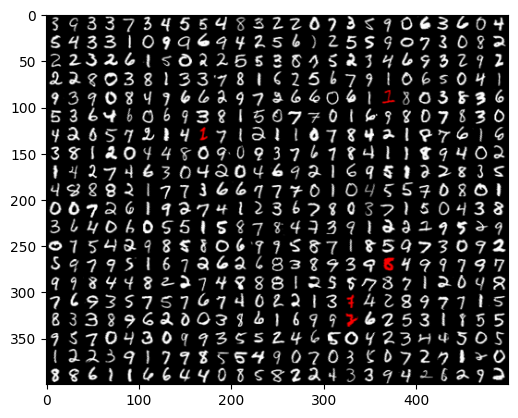

In [17]:
# 保存预测图片
import matplotlib.pyplot as plt
cv2.imwrite("digits-classification.jpg",vis)
plt.imshow(cv2.cvtColor(vis,cv2.COLOR_BGR2RGB))
plt.show()

In [19]:
print(dir(cv2.ml))

['ANN_MLP', 'ANN_MLP_ANNEAL', 'ANN_MLP_BACKPROP', 'ANN_MLP_GAUSSIAN', 'ANN_MLP_IDENTITY', 'ANN_MLP_LEAKYRELU', 'ANN_MLP_NO_INPUT_SCALE', 'ANN_MLP_NO_OUTPUT_SCALE', 'ANN_MLP_RELU', 'ANN_MLP_RPROP', 'ANN_MLP_SIGMOID_SYM', 'ANN_MLP_UPDATE_WEIGHTS', 'ANN_MLP_create', 'ANN_MLP_load', 'BOOST_DISCRETE', 'BOOST_GENTLE', 'BOOST_LOGIT', 'BOOST_REAL', 'Boost', 'Boost_DISCRETE', 'Boost_GENTLE', 'Boost_LOGIT', 'Boost_REAL', 'Boost_create', 'Boost_load', 'COL_SAMPLE', 'DTREES_PREDICT_AUTO', 'DTREES_PREDICT_MASK', 'DTREES_PREDICT_MAX_VOTE', 'DTREES_PREDICT_SUM', 'DTrees', 'DTrees_PREDICT_AUTO', 'DTrees_PREDICT_MASK', 'DTrees_PREDICT_MAX_VOTE', 'DTrees_PREDICT_SUM', 'DTrees_create', 'DTrees_load', 'EM', 'EM_COV_MAT_DEFAULT', 'EM_COV_MAT_DIAGONAL', 'EM_COV_MAT_GENERIC', 'EM_COV_MAT_SPHERICAL', 'EM_DEFAULT_MAX_ITERS', 'EM_DEFAULT_NCLUSTERS', 'EM_START_AUTO_STEP', 'EM_START_E_STEP', 'EM_START_M_STEP', 'EM_create', 'EM_load', 'KNEAREST_BRUTE_FORCE', 'KNEAREST_KDTREE', 'KNearest', 'KNearest_BRUTE_FORCE', '